In [10]:
# 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using Pytorch version : {torch.__version__}, Device : {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10

Using Pytorch version : 1.8.1, Device : cpu


In [12]:
# CIFAR-10 데이터 다운로드 하기 (Train, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = True,
                                      download= True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = False,
                                      transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Files already downloaded and verified


In [13]:
# 데이터 확인하기 (1)
for (X_train, y_train) in train_loader :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break

X_train : torch.Size([32, 3, 32, 32]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor


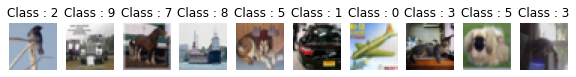

In [14]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
        # pytorch 에선 [mini_batch, channel, height, width], 시각화 하기 위해서 [width, height, channel]로 변경
    plt.title(f'Class : {str(y_train[i].item())}')

In [15]:
# MLP 모델 설계하기
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [16]:
# Optimizer, Objective Function 설정하기
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [17]:
# MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [18]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [21]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200, epoch=Epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f} \tTest Accuracy : {test_accuracy:.2f}\n")

Train Epoch : 1 [0/50000(0%)]	Train Loss : 1.982005000114441
Train Epoch : 1 [6400/50000(13%)]	Train Loss : 1.4245827198028564
Train Epoch : 1 [12800/50000(26%)]	Train Loss : 1.6084182262420654
Train Epoch : 1 [19200/50000(38%)]	Train Loss : 1.4874743223190308
Train Epoch : 1 [25600/50000(51%)]	Train Loss : 1.8426027297973633
Train Epoch : 1 [32000/50000(64%)]	Train Loss : 1.3069876432418823
Train Epoch : 1 [38400/50000(77%)]	Train Loss : 1.413783311843872
Train Epoch : 1 [44800/50000(90%)]	Train Loss : 1.7804268598556519

[EPOCH:1] 	Test Loss : 0.0481 	Test Accuracy : 45.01

Train Epoch : 2 [0/50000(0%)]	Train Loss : 1.3487240076065063
Train Epoch : 2 [6400/50000(13%)]	Train Loss : 1.5841600894927979
Train Epoch : 2 [12800/50000(26%)]	Train Loss : 1.5879027843475342
Train Epoch : 2 [19200/50000(38%)]	Train Loss : 1.459121823310852
Train Epoch : 2 [25600/50000(51%)]	Train Loss : 1.525229811668396
Train Epoch : 2 [32000/50000(64%)]	Train Loss : 1.9003655910491943
Train Epoch : 2 [38400/